# Numerics project option 1
Andrew Brettin  
27 April 2021

Write a solver for the heat equation $u_t = u_{xx}$, $u(x,0) = u_0(x)$, with $u_0(x)$ supported on $[a,b]$ using the central difference approximation and Crank-Nicolson timestepping.

For a boundary condition, use the Neumann-to-Dirichlet map:
$$
u(a,t) = -\frac{1}{\sqrt{\pi}} \int_0^t \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau
$$
and
$$
u(b,t) = \frac{1}{\sqrt{\pi}} \int_0^t \frac{u_x(b,\tau)}{\sqrt{t - \tau}} d\tau
$$

Implementation:  
1. Integrate these boundary conditiFons as a Robin condition for the new timestep  
2. Design a quadrature rule for the integrals. You can compute the integral for a constant approximation of $u_x(a, \tau)$ at each timestep.  

Evaluation:  
1. Test your code on a narrow gaussian initial data $\exp{\frac{-(x - 0.5)^2}{4t_0}}$. With $t_0$ sufficiently small, the data has vanished to machine precision at 0 and 1.  
2. Test convergence against the true solution.

## Part 0: Finding the true solution for homogeneous Neumann boundary conditions
The solution to the IVP in the problem statement is incorrect: it does not satisfy $u_t = u_{xx}$. We will need the true solution for some IVP to evaluate our problem, and we will consider the heat equation with homogeneous boundary conditions:
$$\begin{aligned}
u_t &= u_{xx} \\
u(x,0) &= u_0(x) \\
u_x(0,t) &= u_x(1,t) = 0
\end{aligned}$$

By separation by variables, we can find the true solution to the heat equation with homogeneous Neumann boundary conditions:

$$
u(x,t) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos{(n \pi x)} e^{-(n \pi)^2 t}
$$

where $a_n = 2 \int_0^1 u_0(x) \cos{(n \pi x)} dx$ for all $n = 0, 1, \dots$. 

To compute this solution for evaluating our numerical scheme, we cannot sum up an infinite number of modes. However,  since $u_0(x)$ is $\mathcal{C}^\infty$, we have that $|a_n| \leq M e^{-\alpha n}$ for some $M$ and $\alpha$. Therefore the higher order modes are less important and we can truncate our series at some $N_{max}$. Here, we select $N_{max}$ by computing the error between $u_0(x)=\exp{\frac{-(x - 0.5)^2}{4t_0}}$ and its truncated Fourier series  $\frac{a_0}{2} + \sum_{n=1}^{N_{max}} a_n \cos (n \pi x)$ and see which value of $N_{max}$ is necessary to obtain machine precision.

Another challenge is that the integral for $a_n$ cannot be evaluated with closed form for the given initial value $u_0(x)=\exp{\frac{-(x - 0.5)^2}{4t_0}}$. Therefore, we use scipy's numerical quadrature packages to compute this integral for the purpose of computing the "true" solution, although we will build our own quadrature rule to implement the Neumann-to-Dirichlet map. This seems justifiable, as we are just using it to define our true solution for evaluating our numerics.

In [1]:
import numpy as np
from numpy import array, arange, linspace, logspace, zeros, ones, append
from numpy import pi, e, exp, cos, sin, log, sqrt
from numpy.linalg import solve, norm
eps = np.finfo(float).eps

from scipy.integrate import quad
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import ipywidgets

In [2]:
# Choose t0 exactly small enough so u0 goes to zero at boundary
t0 = -1/(16*log(np.finfo(float).eps)) 
u0 = lambda x : exp(-(x - 1/2)**2/(4*t0))

In [3]:
# Grid setup
a = 0
b = 1
m = 999     # Number of interior gridpoints
dx = (b - a)/(m + 1)

T = 0.5
dt = dx
N = int(T/dt)
r = 0.5 * dt / dx**2

xs = linspace(a, b, m+2)
ts = arange(0, T, dt)
u = xr.DataArray(np.zeros((m+2, N)), dims=('x', 't'),
                coords={'x': xs, 't':ts})
u[{'t':0}] = u0(xs)

In [4]:
# True solution:
def sol(xs,ts,N_max=42):
    u = quad(u0,0,1)[0]*np.ones((len(xs), len(ts)))
    for n in range(1, N_max):
        f = lambda y : u0(y)*cos(n*pi*y)
        u = u + 2*quad(f,0,1)[0]*np.array([[cos(n*pi*x)*exp(-(n*pi)**2 *t) for t in ts] for x in xs])
    u = xr.DataArray(u, dims=('x', 't'), coords={'x':xs, 't':ts})
    return u

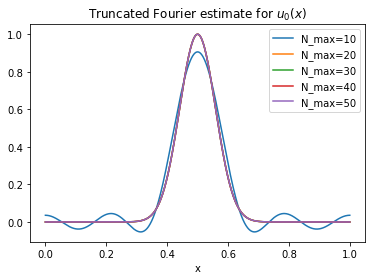

In [5]:
# Plot to see what value of N_max is required to estimate $u_0(x)$:
fig, ax = plt.subplots()
for N in [10, 20, 30, 40, 50]:
    utrue = sol(xs, array([ts[0],]), N_max=N)
    utrue.isel(t=0).plot(ax=ax, label='N_max=' + str(N))
ax.set_title(r'Truncated Fourier estimate for $u_0(x)$')
ax.legend()

It seems like the truncated fourier series is a good estimate for $u_0(x)$ for $N_{max} \approx 20$ or so, but let's check the absolute errors:

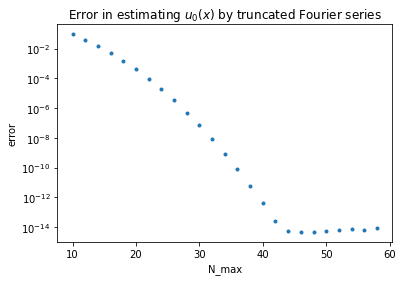

In [6]:
N_list = arange(10, 60, 2)
errors = zeros(len(N_list))
for i in range(len(N_list)):
    utrue = sol(xs, ts[0:1], N_max=N_list[i])
    errors[i] = norm(utrue.isel(t=0)-u0(xs), ord=np.inf)
fig, ax = plt.subplots()
ax.semilogy(N_list, errors, ls='', marker='.')
ax.set(xlabel='N_max', ylabel='error', title=r'Error in estimating $u_0(x)$ by truncated Fourier series');

We can see that with $N_{max} = 42$ we obtain machine precision in our estimate for $u_0(x)$, so we will use this value.

In [7]:
# True solution:
# utrue = sol(xs, ts, N_max=42)

## Part 1: Quadrature rule for integrals

We seek to compute integrals such as 
$$
u(a,t_n) = \frac{1}{\pi} \int_0^{t_n} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau
$$

where $t_n = n\Delta t$. The challenge is that there is a singularity at $t = \tau$. Following [Jiang and Greengard](https://doi.org/10.1016/S0898-1221(04)90079-X), we will divide the integral into a local part $I_L$ and a history part $I_H$:

$$
\int_0^{n \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau = \int_0^{(n-1) \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau + \int_{(n-1) \Delta t}^{n \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau
$$

where the local part is $I_L = \int_{(n-1) \Delta t}^{n \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau$ and the history part is $I_H = \int_0^{(n-1) \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau$.

The local part can be computed to second order by Taylor expanding $\sigma(s) = u_x(a,s)$ for $s \in [t - \Delta t, t]$ and then using a forward difference approximation to $\sigma'(t - \Delta t)$:

$$\begin{aligned}
\sigma(s) &= \sigma(t - \Delta t) + \sigma'(t - \Delta t) (s - (t-\Delta t)) + \mathcal{O}(\Delta t^2) \\
&= \sigma(t - \Delta t) + \frac{\sigma(t) - \sigma(t-\Delta t)}{\Delta t} (s - (t-\Delta t)) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

so that 
$$
I_L \approx \int_{(n-1) \Delta t}^{n \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau = \sqrt{\Delta t} \left(\frac{4}{3}u_x(a,t) + \frac{2}{3}u_x(a, t - \Delta t) \right)
$$

We will use the trapezoidal rule to estimate the integrand $I_H$ to obtain $\mathcal{O}(\Delta t^2)$ accuracy. Since $I_L = \mathcal{O}(\Delta t^{2.5})$, we will end up with a second-order accurate estimate for $u_a$. Jiang and Greengard explain a method to get a machine-precision estimate for $I_H$, but we will use the trapezoid rule for simplicity:

$$\begin{aligned}
I_H &= \int_0^{(n-1) \Delta t} \frac{u_x(a,\tau)}{\sqrt{t - \tau}} d\tau \\
&= \Delta t \left( \frac{1}{2}f(0) + \sum_{k=1}^{n-2} f(k\Delta t) + \frac{1}{2}f((n-1)\Delta t) \right) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

Finally, we note that the expression for $u(b, t_n)$ is computed similarly to $u(a,t_n)$.

In [8]:
def I_H(tk, u_x):
    '''
    Returns the history part of the integral I_H using the trapezoidal rule.
    Parameters:
        tk : np.array
            integration abscissas, ignoring the last element (which is handled by I_L).
        u_x : function
            Neumann condition as a function of time.
    '''
    f = lambda t : u_x(t)/sqrt(tk[-1] - t)
    if len(tk) <= 2:
        return 0
    else:
        dt = tk[1] - tk[0]
        return dt * (0.5*f(tk[0]) + 0.5*f(tk[-2]) + sum([f(t) for t in tk[1:-2]]))

def I_L(tk, u_x):
    '''
    Returns the local part of the integral, I_L, by approximating u_x as a linear function.
    '''
    if len(tk) == 1:
        return 0
    else:
        dt = tk[-1] - tk[-2]
        return sqrt(dt) * (4/3*u_x(tk[-1]) + 2/3*u_x(tk[-2]))

def u_a(t):
    tk = ts[ts <=t]
    return 1/sqrt(pi)*(I_H(tk, ux_a) + I_L(tk, ux_a))

def u_b(t):
    tk = ts[ts <=t]
    return -1/sqrt(pi)*(I_H(tk, ux_a) + I_L(tk, ux_b))

## Part 2: Integrate boundary conditions

In [9]:
# Example boundary conditions for testing, assuming part 1 is complete
u_a = lambda t : 0
u_b = lambda t : 0

A1 = np.diag((1 + 2*r)*ones(m), 0) + np.diag(-r*ones(m-1), 1) + np.diag(-r*ones(m-1), -1)
A2 = np.diag((1 - 2*r)*ones(m), 0) + np.diag(r*ones(m-1), 1) + np.diag(r*ones(m-1), -1)

In [10]:
# Iterate and compute values
for j in range(0, N-1):
    u_last = np.array(u.isel(t=j))[1:-1] # Interior last values
    b = A2 @ u_last
    b[0] = b[0] + r * (u_a(ts[j]) + u_a(ts[j+1]))
    b[m-1] = b[m-1] + r * (u_b(ts[j]) + u_b(ts[j+1]))
    u_next = solve(A1, b)
    u[:,j+1] = [u_a(ts[j+1]), *u_next, u_b(ts[j+1])]

## Plotting and Animation
We show a few plots for the simulation with homogeneous Dirichlet boundary conditions as a proof of functionality.

Text(0.5, 1.0, 'Numerical solution of heat equation, homogeneous Dirichlet BC')

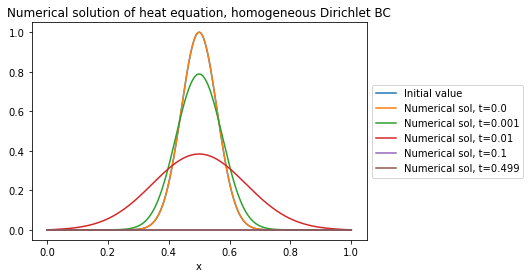

In [11]:
fig, ax = plt.subplots()
u.isel(t=0).plot(ax=ax, label='Initial value')
for j in [0, 1, 10, 100, -1]:
    u.isel(t=j).plot(ax=ax, label='Numerical sol, t={}'.format(ts[j]))
ax.legend(bbox_to_anchor=[1,0.5], loc='center left')
ax.set_title('Numerical solution of heat equation, homogeneous Dirichlet BC')

Text(0.5, 1.0, 'Numerical solution of heat equation, homogeneous Dirichlet BC')

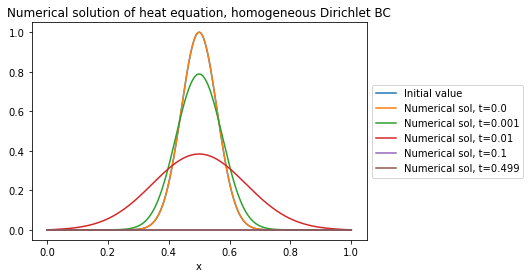

In [12]:
# True solution
fig, ax = plt.subplots()
u.isel(t=0).plot(ax=ax, label='Initial value')
for j in [0, 1, 10, 100, -1]:
    u.isel(t=j).plot(ax=ax, label='Numerical sol, t={}'.format(ts[j]))
ax.legend(bbox_to_anchor=[1,0.5], loc='center left')
ax.set_title('Numerical solution of heat equation, homogeneous Dirichlet BC')

Next, we will save an mp4 animation of the simulation. This will be available on [my GitHub](https://github.com/andrewbrettin/Tomfoolery/tree/master/numerics_project).

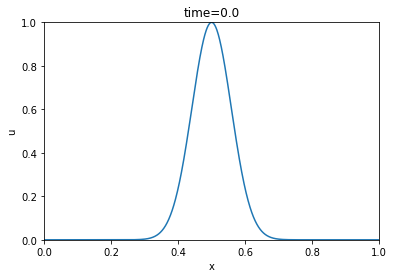

In [13]:
# Save an mp4 animation of the simulation
fig, ax = plt.subplots()
ax.set(xlim=(0,1), ylim=(0,1))

X, T = np.meshgrid(xs, ts)
data = u.data

line = ax.plot(xs, data[:,0])[0]

def animate(j):
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title('time={}'.format(np.round(ts[j], 3)))
    line.set_ydata(data[:,j])

anim = FuncAnimation(fig, animate, interval=25, frames=len(ts)-1, repeat=False)
plt.draw()
plt.show()

# anim.save('simulation.mp4', writer="imagemagick")

This cell implements an interactive widget where a slider can be toggled to cycle through frames of the simulation, and may not be interactive on GitHub or nbviewer.

In [14]:
# Create interactive widget
def plot_u(rec):
    data = u[:,rec]
    plt.plot(xs, data)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('time={}'.format(np.round(ts[rec], 3)))

ipywidgets.interact(plot_u, rec=(0,len(ts)-1,1))

interactive(children=(IntSlider(value=249, description='rec', max=499), Output()), _dom_classes=('widget-inter…

<function __main__.plot_u(rec)>

## Packaging
A model class was created which initializes a Neumann to Dirichlet boundary condition. Here we explore a few instances.

In [15]:
from heat_equation_ntd import HeatEquation

model = HeatEquation()
help(model)

Help on HeatEquation in module heat_equation_ntd object:

class HeatEquation(builtins.object)
 |  HeatEquation(a=0, b=1, m=999, T=0.5, dt=None, u0=None, neumann=True, ux_a=<function HeatEquation.<lambda> at 0x7fda8362e1f0>, ux_b=<function HeatEquation.<lambda> at 0x7fda8362eb80>)
 |  
 |  Model for numerically solving the heat equation with von Neumann boundary conditions.
 |  .. math::
 |      u_t = u_xx, x \in [a,b]
 |      u(x,0) = u_0(x)
 |      u_x(a, t) = f_1(t)
 |      u_x(b, t) = f_2(t)
 |  
 |  The solution is expected to be compactly supported on [a,b], and the von Neumann 
 |  boundary conditions are handled via the Neumann to Dirichlet transform.
 |  
 |  Parameters:
 |      a : float
 |          Left endpoint of domain.
 |      b : float
 |          Right endpoint of domain.
 |      m : int
 |          Number of interior gridpoints.
 |      dx : float
 |          Grid spacing.
 |      T : float
 |          Total timespan of simulation
 |      dt : float
 |          Timeste

Simulation with homogeneous Dirichlet boundary conditions:

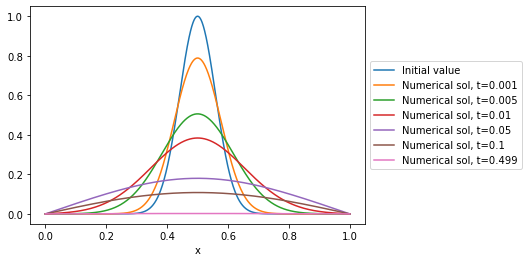

In [16]:
model = HeatEquation(neumann=False)
model.run()
model.plot()

Simulation with homogeneous von Neumann boundary conditions:

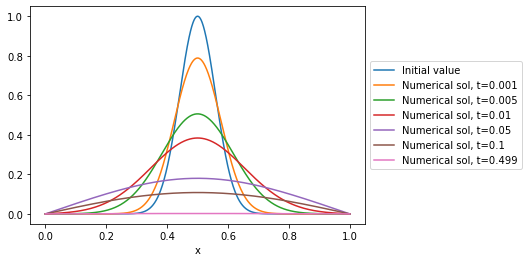

In [17]:
ux_a = lambda t : 0
ux_b = lambda t : 0
model = HeatEquation(ux_a=ux_a, ux_b=ux_b)
model.run()
model.plot()

Compare to true solution with homogeneous von Neumann boundary conditions:

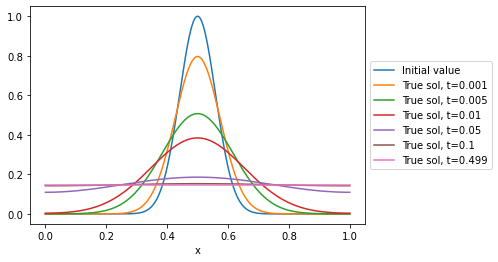

In [18]:
model.plot_true_sol()

We can see that there are differences in the numerical solution from the true solution. Unfortunately, something seems to go wrong when using the Neumann-to-Dirichlet map on homogeneous Neumann conditions, as this results in homogeneous Dirichlet conditions. In actuality, the boundary conditions should move up so that the solution retains its integral (as a rod would homogenize but retain its total heat content when imposing no net heat flux on the boundaries).

Boundary conditions $u_x(a,t) = 1$, $u_x(b,t) = 1$:

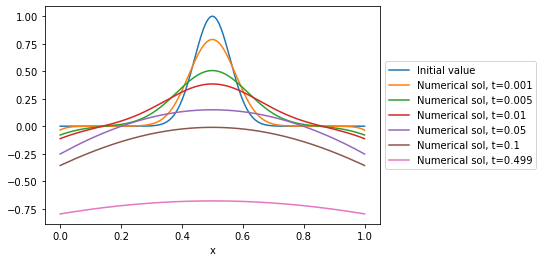

In [19]:
ux_a = lambda t : 1
ux_b = lambda t : -1
model = HeatEquation(ux_a=ux_a, ux_b=ux_b)
model.run()
model.plot()

Simulation with boundary conditions $u_x(a,t) = 0$, $u_x(b,t) = \frac{1}{t+0.1}$

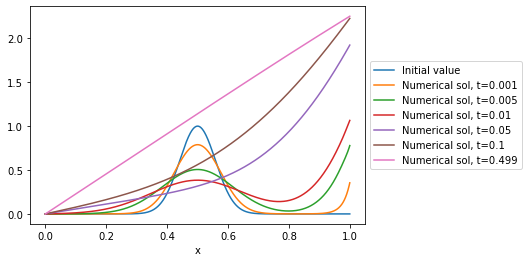

In [20]:
ux_a = lambda t : 0
ux_b = lambda t : 1/(t+0.1)
model = HeatEquation(neumann=True, ux_a=ux_a, ux_b=ux_b)
model.run()
model.plot()

<!-- ## Evaluation -->

<!-- # Loglog plot of error vs m at some future time t -->

<!-- # Numerical solution for various times -->